## Heuristic 4 

### Description
If there are multiple (say 12) deposit transactions coming from a deposit address and later there are 12 withdraw transactions to the same withdraw address, then we can link all these deposit transactions to the withdraw transactions.

In particular, given a withdrawal transaction, an anonimity score is assigned to it:

1) The number of previous withdrawal transactions with the same address as the given withdrawal transaction is registered.

2) The deposit transactions data are grouped by their address. Addresses that deposited the same number of times as the number of withdraws registered, are grouped in a set $C$.

3) An anonimity score (of this heuristic) is assigned to the withdrawal transaction following the formula $P = 1 - 1/|C|$, where P is the anonimity score and $|C|$ is the cardinality of set $C$.

In [23]:
# Set environment variables to better visualize DataFrames.
ENV["COLUMNS"]=10000
ENV["LINES"]=10;

In [24]:
# Import relevant packages.
using DataFrames
using CSV
using StatsPlots
using ProgressBars

In [25]:
# Load withdraw and deposit data.
withdraw_transactions_df = CSV.read("../data/lighter_complete_withdraw_txs.csv", DataFrame)
deposit_transactions_df = CSV.read("../data/lighter_complete_deposit_txs.csv", DataFrame);

In [26]:
tornado_addresses = Dict(
    "0xd4b88df4d29f5cedd6857912842cff3b20c8cfa3" => "100 DAI",
    "0xfd8610d20aa15b7b2e3be39b396a1bc3516c7144" => "1000 DAI",
    "0x07687e702b410fa43f4cb4af7fa097918ffd2730" => "10000 DAI",
    "0x23773e65ed146a459791799d01336db287f25334" => "100000 DAI",
    "0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc" => "0.1 ETH",
    "0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936" => "1 ETH",
    "0x910cbd523d972eb0a6f4cae4618ad62622b39dbf" => "10 ETH",
    "0xa160cdab225685da1d56aa342ad8841c3b53f291" => "100 ETH",
    "0xd96f2b1c14db8458374d9aca76e26c3d18364307" => "100 USDC",
    "0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d" => "1000 USDC",
    "0x169ad27a470d064dede56a2d3ff727986b15d52b" => "100 USDT",
    "0x0836222f2b2b24a3f36f98668ed8f0b38d1a872f" => "1000 USDT",
    "0x178169b423a011fff22b9e3f3abea13414ddd0f1" => "0.1 WBTC",
    "0x610b717796ad172b316836ac95a2ffad065ceab4" => "1 WBTC",
    "0xbb93e510bbcd0b7beb5a853875f9ec60275cf498" => "10 WBTC",
    "0x22aaa7720ddd5388a3c0a3333430953c68f1849b" => "5000 cDAI",
    "0x03893a7c7463ae47d46bc7f091665f1893656003" => "50000 cDAI",
    "0x2717c5e28cf931547b621a5dddb772ab6a35b701" => "500000 cDAI",
    "0xd21be7248e0197ee08e0c20d4a96debdac3d20af" => "5000000 cDAI"
    );

### Function summary: compare_transactions

Given two dictionaries, withdraw_dict and deposit_dict representing the total deposits and withdraws made by an address to each TCash pool, respectively, compares if the set of keys of both are equal and when they are, checks if all values in the deposit dictionary are equal or greater than each of the corresponding values of the withdraw dicionary. If this is the case, returns $True$, if not, $False$.

In [27]:
function compare_transactions(withdraws_dict, deposits_dict)
    for currency in keys(withdraws_dict)
        if !(deposits_dict[currency] >= withdraws_dict[currency])
            return false
        end
    end
    return true
end

compare_transactions (generic function with 1 method)

### Function summary: get_number_of_withdraws
Given a withdraw transaction and the total withdrawals data, the function get_number_of_withdraws returns the number of previous withdrawal transactions with the same address as the withdraw transaction.

In [28]:
function get_number_of_withdraws(withdraw_transaction, withdraw_transactions_df, tornado_addresses)
    
    # The number of withdraws is initialized at 1 since the withdraw_transaction of the first argument is always present
    # in the withdrawal data. Also, the count should be 1 if there is no other transaction with the same address.
    
    n_withdraws = Dict(tornado_addresses[withdraw_transaction.tornado_cash_address] => 1)
    
    # This for loop counts the number of transactions with the same address. At the end, the total number is returned.
    # The count is done considering that the recipient_address of each of the transactions in the withdraw_transactions_df
    # is the same as the recipient_address of the withdraw_transaction input, and that the timestamp of the rows is earlier
    # than the withdraw_transaction input. 
    # The if clause also filters by the transaction hash, since we don't want to count the same transaction two times.
    
    for row ∈ eachrow(withdraw_transactions_df)
        if (row.recipient_address == withdraw_transaction.recipient_address) && 
            (row.block_timestamp <= withdraw_transaction.block_timestamp) && 
            (row.hash != withdraw_transaction.hash)
            
            if haskey(n_withdraws, tornado_addresses[row.tornado_cash_address])
                n_withdraws[tornado_addresses[row.tornado_cash_address]] += 1
            else
                n_withdraws[tornado_addresses[row.tornado_cash_address]] = 1
            end
        end
    end
    return n_withdraws
end

get_number_of_withdraws (generic function with 1 method)

### Function summary: get_address_deposits

Given the deposit transactions DataFrame, returns a dictionary with every address of the deposit

In [29]:
function get_address_deposits(deposit_transactions_df, tornado_addresses)
    # unique_addresses = unique(deposit_transactions_df[!, "from_address"])
    
    addresses_and_deposits_counts = combine(groupby(deposit_transactions_df, [:from_address, :tornado_cash_address]), nrow => :count)
    
    addresses_and_deposit_dict = Dict()
    for row in eachrow(addresses_and_deposits_counts)
        if haskey(addresses_and_deposit_dict, row.from_address)
             if haskey(addresses_and_deposit_dict[row.from_address], tornado_addresses[row.tornado_cash_address])
                 addresses_and_deposit_dict[row.from_address][tornado_addresses[row.tornado_cash_address]] += row.count
             else
                addresses_and_deposit_dict[row.from_address][tornado_addresses[row.tornado_cash_address]] = row.count
             end
        else
            addresses_and_deposit_dict[row.from_address] = Dict(tornado_addresses[row.tornado_cash_address] => row.count)
        end
    end
    
    return addresses_and_deposit_dict
end

get_address_deposits (generic function with 1 method)

In [30]:
address_deposits = get_address_deposits(deposit_transactions_df, tornado_addresses)

Dict{Any, Any} with 23504 entries:
  "0x23f11f0571e392390929ec909be393fd93e79eb6" => Dict("1 ETH"=>2)
  "0x390e817d1c8f764dd4228d67dfbe85ee5de2fbcf" => Dict("10 ETH"=>1, "100 ETH"=>1)
  "0xa3a0a77d44ab389b1bbfdd6305a82a872449c8a1" => Dict("10 ETH"=>9, "1 ETH"=>8)
  "0x7b590b11f20f5e942f7b39f05b6827f4787cf435" => Dict("100000 DAI"=>1)
  "0x110790db185798abc9fc14570a60eab346ad6dbd" => Dict("1 ETH"=>1)
  ⋮                                            => ⋮

In [31]:
get_number_of_withdraws(withdraw_transactions_df[3,:], withdraw_transactions_df, tornado_addresses)

Dict{String, Int64} with 3 entries:
  "1000 USDC" => 2
  "100 ETH"   => 1
  "0.1 ETH"   => 1

In [32]:
d = Dict("1 ETH" => 93,
  "100 ETH" => 4,
  "1 WBTC" => 3,
  "0.1 ETH" => 1,
  "0.1 WBTC" => 1)

Dict{String, Int64} with 5 entries:
  "0.1 WBTC" => 1
  "1 ETH"    => 93
  "100 ETH"  => 4
  "1 WBTC"   => 3
  "0.1 ETH"  => 1

### Function summary: get_same_or_more_number_of_deposits
Given a number of withdrawal transactions, the function registers all the addresses that have made that same number of deposits. Returns an array with all the addresses that match these requirements.

In [33]:
function get_same_or_more_number_of_deposits(n_withdraws, address_deposits, tornado_addresses)
    filter(address_deposit -> (Set(keys(n_withdraws))) == Set(keys(last(address_deposit))) &&
                                    compare_transactions(n_withdraws, last(address_deposit)),
                                address_deposits) |> keys |> collect
    
end

get_same_or_more_number_of_deposits (generic function with 1 method)

In [34]:
get_same_or_more_number_of_deposits(d, address_deposits, tornado_addresses)

1-element Vector{Any}:
 "0x6e8df51931f8675cf7e12447e1fe25b26c8775c7"

### Function summary: get_same_number_of_deposits_heuristic
Given a withdraw_transaction and the deposit and withdraw data, compute the anonimity score of the transaction, based on this heuristic.

In [35]:
function same_number_of_deposits_heuristic(withdraw_transaction, address_deposits, withdraw_transactions_df, tornado_addresses)
                                                              
    # We calculate the number of withdrawals of the address from the withdraw_transaction given as input.
    
    n_withdraws = get_number_of_withdraws(withdraw_transaction, withdraw_transactions_df, tornado_addresses)
        
    # Based on n_withdraws, the set of the addresses that have the same number of deposits is calculated.
    
    Ϛ = get_same_or_more_number_of_deposits(n_withdraws, address_deposits, tornado_addresses)
    
    # The anonimity score P is computed.
    
    P = 1 - 1/length(Ϛ)
    
    # Since there is a chance that the cardinality of the set is 0, we handle this case and return the anonimity
    # score.
    
    return isinf(P) ? 1 : P
end

same_number_of_deposits_heuristic (generic function with 1 method)

In [36]:
function apply_same_number_of_deposits_heuristic(deposit_transactions_df, withdraw_transactions_df, tornado_addresses)
    
    address_deposits = get_address_deposits(deposit_transactions_df, tornado_addresses)
    
    # An empty dictionary is initialized. It will be used to store the anonimity score associated with each transaction.
    
    tx_hash_and_anonimity_score = Dict()
    
    # Iterate over every row of the withdraw_transactions DataFrame and apply the function same_number_of_deposits_heuristic
    # For each transaction, the anonimity score is computed and appended to the dictionary.
    
    for withdraw_row ∈ ProgressBar(eachrow(withdraw_transactions_df), printing_delay=5)
        anonimity_score = same_number_of_deposits_heuristic(withdraw_row, address_deposits, withdraw_transactions_df, tornado_addresses)
        tx_hash_and_anonimity_score[withdraw_row.hash] = anonimity_score
    end
    
    # The dictionary with the transaction hashes and scores is returned
    
    tx_hash_and_anonimity_score
end

apply_same_number_of_deposits_heuristic (generic function with 1 method)

We apply this last function to our data and we obtain a dictionary indicating the score of each withdrawal.

In [37]:
scores = apply_same_number_of_deposits_heuristic(deposit_transactions_df, withdraw_transactions_df, tornado_addresses)


0.0%┣                                     ┫ 0/83.8k [00:05<-116:-21:-50, -5s/it]
0.0%┣                                        ┫ 1/83.8k [00:05<Inf:Inf, InfGs/it]
0.1%┣                                         ┫ 97/83.8k [00:10<02:29:31, 9it/s]
0.2%┣                                       ┫ 196/83.8k [00:15<01:49:26, 13it/s]
0.4%┣▏                                      ┫ 298/83.8k [00:20<01:35:13, 15it/s]
0.5%┣▏                                      ┫ 400/83.8k [00:25<01:28:15, 16it/s]
0.6%┣▎                                      ┫ 501/83.8k [00:30<01:24:18, 16it/s]
0.7%┣▎                                      ┫ 599/83.8k [00:35<01:22:02, 17it/s]
0.8%┣▎                                      ┫ 696/83.8k [00:40<01:20:32, 17it/s]
0.9%┣▍                                      ┫ 795/83.8k [00:45<01:19:12, 17it/s]
1.1%┣▍                                      ┫ 892/83.8k [00:51<01:18:19, 18it/s]
1.2%┣▌                                      ┫ 988/83.8k [00:56<01:17:39, 18it/s]
1.3%┣▌                      

LoadError: InterruptException:

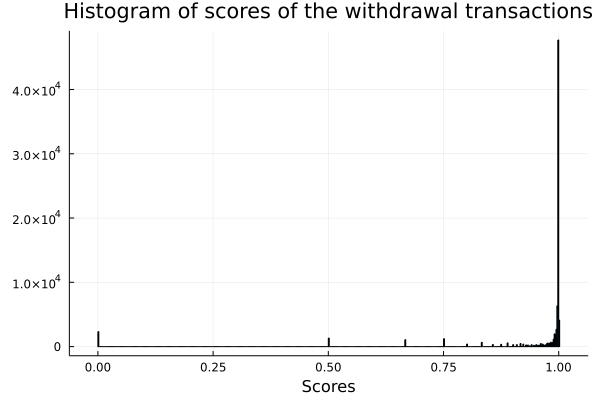

In [20]:
score_values = values(scores) |> collect
histogram(score_values, bins=500, legend=false, title="Histogram of scores of the withdrawal transactions", xlabel="Scores")

In [21]:
#CSV.write("../data/fourth_heuristic_results.csv", scores)

### Linked addresses
So if a withdraw score is equal to  0, it means that there is only 1 possible deposit address that can be linked to the `withdraw.rerecipient_address`. We will assume that these addresses are linked.

In [85]:
linkend_transactions = filter(row -> row.score == 0 , scores)

,transaction_hash,score
,String,Float64
1,0xab8c990fd03a68b5a72679176819f3307b94dd27fccb528dc968fbd117e0cd74,0.0
2,0x7bcbfc18032880f11d9f7ef839ecd7994c7f21acd16c9e2c1296b1f1132cb8c7,0.0
3,0x1de4f78fb430182f8da97af732fb964851f4ff9264b0b4782a24e887c4ce1ce2,0.0
4,0x353502ed733db02f94873531898ce7677d6bbac02f28953e32d6c1678ab0a037,0.0
5,0x42c7c20b00d6c69f482414fb1f9a8ae44b404ac0c54965c9699dbf8a0116dfff,0.0
6,0x57278344d3aecef4c88edc9b4f828e9bceb0229131bfd3a0c3873ab1da4c901f,0.0
7,0xc146ba265a17a3e7115d8d6072d4d5d5d6da781d1f9a3a579205b3a97357ffd3,0.0
8,0xe4e1c52c9f95e23abe9118d881f6696e79064ea0b1d1bc54c94514269dee2299,0.0
9,0x4853981ae30fcd76b5babb035cca512b5ad79874f77fa030e5e054084398deb3,0.0


In [86]:
function get_withdraw_address(linked_hash, withdraw_transactions_df)
    idx = findfirst(hash -> hash == linked_hash, withdraw_transactions_df[!, :hash])
    withdraw_transactions_df[idx, :recipient_address]
end

get_withdraw_address (generic function with 1 method)

In [87]:
function get_deposit_address(linked_hash, withdraw_transactions_df, address_deposits,tornado_addresses)
    
    # Get withdraw transaction
    idx = findfirst(hash -> hash == linked_hash, withdraw_transactions_df[!, :hash])
    withdraw_transaction = withdraw_transactions_df[idx, :]

    # We calculate the number of withdrawals of the address from the withdraw_transaction given as input.
    n_withdraws = get_number_of_withdraws(withdraw_transaction, withdraw_transactions_df, tornado_addresses)

    # Based on n_withdraws, the set of the addresses that have the same number of deposits is calculated.
     Ϛ = get_same_or_more_number_of_deposits(n_withdraws, address_deposits, tornado_addresses)
    
    # Since the score of the input linked_hash is 0, Ϛ must contain just 1 deposit address
    if length(Ϛ) == 1 
        return Ϛ[1]
    else
        return "error"
    end
end

get_deposit_address (generic function with 1 method)

In [88]:
linkend_transactions.withdraw_address = [get_withdraw_address(row.transaction_hash, withdraw_transactions_df) for row in eachrow(linkend_transactions)]
linkend_transactions.deposit_address = [get_deposit_address(row.transaction_hash, withdraw_transactions_df, address_deposits,tornado_addresses) for row in eachrow(linkend_transactions)]
linkend_transactions

,transaction_hash,score,withdraw_address,deposit_address
,String,Float64,String,String
1,0xab8c990fd03a68b5a72679176819f3307b94dd27fccb528dc968fbd117e0cd74,0.0,0x7f182fe7ab9a186deb61dfe8fe1dc518da51b8c1,0x7f182fe7ab9a186deb61dfe8fe1dc518da51b8c1
2,0x7bcbfc18032880f11d9f7ef839ecd7994c7f21acd16c9e2c1296b1f1132cb8c7,0.0,0x1e9b50040e373b387d596b366132be53fe3fc667,0xbe2ae891e9c8e0ff1eee1467e36cf055a1a4f709
3,0x1de4f78fb430182f8da97af732fb964851f4ff9264b0b4782a24e887c4ce1ce2,0.0,0x68661550f759a41d65a8eefd3e47dd606ca76ae2,0x09bdff1a9d98a1fb81d982ad2b192dd49a932296
4,0x353502ed733db02f94873531898ce7677d6bbac02f28953e32d6c1678ab0a037,0.0,0xe44799ef334df157e0f8e2855e5ebebdbc02b299,0xe44799ef334df157e0f8e2855e5ebebdbc02b299
5,0x42c7c20b00d6c69f482414fb1f9a8ae44b404ac0c54965c9699dbf8a0116dfff,0.0,0xd88189f7dee6e5dbd6cbc6f06fd357f4bf7f330b,0x516a24e7691b34752772a699962e1b632fd083c0
6,0x57278344d3aecef4c88edc9b4f828e9bceb0229131bfd3a0c3873ab1da4c901f,0.0,0x50adf7a75d7cd6132acc0a2fb21c019011286635,0x50adf7a75d7cd6132acc0a2fb21c019011286635
7,0xc146ba265a17a3e7115d8d6072d4d5d5d6da781d1f9a3a579205b3a97357ffd3,0.0,0xe4b424e1ccc6f08768c921455f83181bacbfe3f0,0xe0e484dfa7f3aa36733a915d6f07eb5a57a74a11
8,0xe4e1c52c9f95e23abe9118d881f6696e79064ea0b1d1bc54c94514269dee2299,0.0,0x7de27209440cac3707ac0114337ffb2e0b87b4ee,0xd8e0016879fe8904988315317e622e48176820b6
9,0x4853981ae30fcd76b5babb035cca512b5ad79874f77fa030e5e054084398deb3,0.0,0x6e8df51931f8675cf7e12447e1fe25b26c8775c7,0x4c27508f0a35220c87abf3b5f255259ce82408ba


In [89]:
linked_addresses = combine(groupby(linkend_transactions, [:withdraw_address, :deposit_address]), nrow => :count)[!, [:withdraw_address, :deposit_address]]

,withdraw_address,deposit_address
,String,String
1,0x7f182fe7ab9a186deb61dfe8fe1dc518da51b8c1,0x7f182fe7ab9a186deb61dfe8fe1dc518da51b8c1
2,0x1e9b50040e373b387d596b366132be53fe3fc667,0xbe2ae891e9c8e0ff1eee1467e36cf055a1a4f709
3,0x68661550f759a41d65a8eefd3e47dd606ca76ae2,0x09bdff1a9d98a1fb81d982ad2b192dd49a932296
4,0xe44799ef334df157e0f8e2855e5ebebdbc02b299,0xe44799ef334df157e0f8e2855e5ebebdbc02b299
5,0xd88189f7dee6e5dbd6cbc6f06fd357f4bf7f330b,0x516a24e7691b34752772a699962e1b632fd083c0
6,0x50adf7a75d7cd6132acc0a2fb21c019011286635,0x50adf7a75d7cd6132acc0a2fb21c019011286635
7,0xe4b424e1ccc6f08768c921455f83181bacbfe3f0,0xe0e484dfa7f3aa36733a915d6f07eb5a57a74a11
8,0x7de27209440cac3707ac0114337ffb2e0b87b4ee,0xd8e0016879fe8904988315317e622e48176820b6
9,0x6e8df51931f8675cf7e12447e1fe25b26c8775c7,0x4c27508f0a35220c87abf3b5f255259ce82408ba


In [90]:
#CSV.write("../data/fourth_heuristic_linked_addresses.csv", linked_addresses)

"../data/fourth_heuristic_linked_addresses.csv"